In [233]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [234]:
# Data API
!pip install yahoo_fin statsmodels >> /dev/null

In [235]:
import pandas as pd
import numpy as np
from collections import Counter
import os

# Data API
import yahoo_fin.stock_info as si

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Cointegration Testing
from statsmodels.tsa.stattools import coint

# Stationarity Testing
from statsmodels.tsa.stattools import adfuller

# Pair Selection 
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [236]:
START_DATE = pd.Timestamp("2016-01-04")
END_DATE = pd.Timestamp("2017-12-29")
TRADING_DAYS = 2*250

In [237]:
sp500_list = si.tickers_sp500()

In [238]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [239]:
# data_dir = os.path.join('/','content','gdrive','MyDrive','trading_pairs')
# data_path = os.path.join(data_dir, 'S&P500_stock_data.csv')
# test_data_path = os.path.join(data_dir, 'S&P500_stock_data_test.csv')
# raw_data_path = os.path.join(data_dir, 'S&P500_raw.csv')



data_dir = ''
data_path = os.path.join(data_dir, 'S&P500_stock_data.csv')
test_data_path = os.path.join(data_dir, 'S&P500_stock_data_test.csv')
raw_data_path = os.path.join(data_dir, 'S&P500_raw.csv')

In [240]:
# !ls gdrive/MyDrive/trading_pairs


In [241]:
data_path

'S&P500_stock_data.csv'

In [242]:
if os.path.isfile(data_path):
    # Load Files
    data = pd.read_csv(data_path)
    test_data = pd.read_csv(test_data_path)
    data = data.set_index('date')
    test_data = test_data.set_index('date')
    raw_data = pd.read_csv(raw_data_path)
    raw_data.reset_index(drop = True, inplace = True)
    raw_data = raw_data.pivot(index = 'date', columns = 'ticker', values = ['high', 'low'])
else:
    # Download Files
    sp500_historical_data = {}
    for ticker in sp500_list:
        try:
            sp500_historical_data[ticker] = si.get_data(ticker, 
                                                        start_date=START_DATE, 
                                                        index_as_date = False,
                                                        end_date=END_DATE,
                                                        interval="1d")
        # Tickers listed later than the period
        except AssertionError:
            print("{} Listed Later".format(ticker))
            continue
        
        # yahoo_fin has issues with some tickers
        except KeyError:
            print("{} Malformed Data".format(ticker))
            continue

    data = pd.concat(sp500_historical_data)
    data.reset_index(drop = True, inplace = True)
    data = data.pivot(index = 'date', columns = 'ticker', values = 'adjclose')
    data, test_data = data[:TRADING_DAYS//2], data[TRADING_DAYS//2:]
    data.to_csv(data_path)
    test_data.to_csv(test_data_path)

    # Process data for daily High/Low
    raw_data =  pd.concat(sp500_historical_data)
    raw_data.reset_index(drop = True, inplace = True)
    raw_data.to_csv(raw_data_path)
    raw_data = raw_data.pivot(index = 'date', columns = 'ticker', values = ['high', 'low'])


# Dealing with missing data

Yahoo finance gives us very refined data. To improve visibility we truncate all numbers to have at most 3 digits after the decimal.

In [243]:
pd.set_option('precision',3)
data.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
A,250.0,41.479,3.544,33.152,38.266,42.906,44.361,46.402
AAL,250.0,36.647,4.850,24.285,33.676,36.775,39.246,47.969
AAP,250.0,152.243,9.373,133.517,145.108,151.640,158.441,173.310
AAPL,250.0,24.390,1.882,21.067,22.557,24.550,25.961,27.725
ABBV,250.0,48.091,3.166,40.050,45.610,48.785,50.451,53.709
ABC,250.0,75.932,5.319,63.237,72.255,76.817,79.573,93.532
ABMD,250.0,105.020,15.097,71.000,94.395,104.535,117.775,131.740
ABT,250.0,36.852,2.058,32.775,35.276,36.571,38.429,41.350
ACN,250.0,103.547,6.839,84.809,101.484,105.164,108.375,116.266
ADBE,250.0,97.277,7.787,73.850,93.270,97.710,103.500,110.810


In [244]:
print('Data shape before:', data.shape)

null_percentage = data.isnull().sum() / data.shape[0]
to_drop = null_percentage[null_percentage > 0.2].index
data.drop(labels=to_drop, axis=1, inplace=True)

print('Data shape after:', data.shape)

# Fill null values
data = data.fillna(method = 'ffill')

Data shape before: (250, 497)
Data shape after: (250, 493)


In [245]:
later_added = data.isnull().any()
later_added = later_added[later_added == True] 
data.drop(labels=later_added.index, axis=1, inplace=True)

print('Shape after removing added later', data.shape)

Shape after removing added later (250, 493)


Traditionally what we are interested are not the prices but the returns, so we convert to them.

### Removing Stationary Series

In [246]:
to_drop = []

for ticker in data.columns:
    pval = adfuller(data[ticker])[1]
    
    if pval < 0.05:
        to_drop.append(ticker)
    

In [247]:
print(len(to_drop))

21


In [248]:
data = data.drop(columns=to_drop)
print(len(data.columns))

472


### Creating Returns and Volatility DF

In [249]:
# EDIT: тук деля на 2 защото в data имаме само 250 trading days
ret = data.pct_change().mean()*TRADING_DAYS/2
volatility = data.pct_change().std()*np.sqrt(TRADING_DAYS/2)
returns = pd.DataFrame(index =  data.columns)
returns['returns'] = ret.values
returns['volatility'] = volatility.values

returns.head(5)

,returns,volatility
A,0.152,0.234
AAL,0.231,0.365
AAP,0.150,0.270
AAPL,0.153,0.234
ABBV,0.153,0.272


In [250]:
# Scale values
scale = StandardScaler().fit(returns)

scaled_data = pd.DataFrame(scale.fit_transform(returns), 
                           columns = returns.columns, 
                           index = returns.index)
X = scaled_data
X.head()

,returns,volatility
A,-0.255,-0.331
AAL,0.127,0.979
AAP,-0.266,0.035
AAPL,-0.254,-0.331
ABBV,-0.253,0.049


# Clustering of data rel returns and volatility

After all the preprocessing and normalization, we now proceed to use standard clustering algorithms to group them based on returns and volatility.


## K-means
 We use the most standard clustering algorithm.


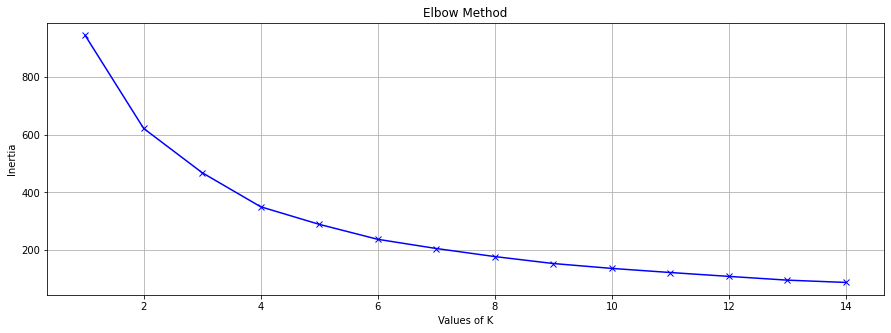

In [251]:

K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
                                        

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

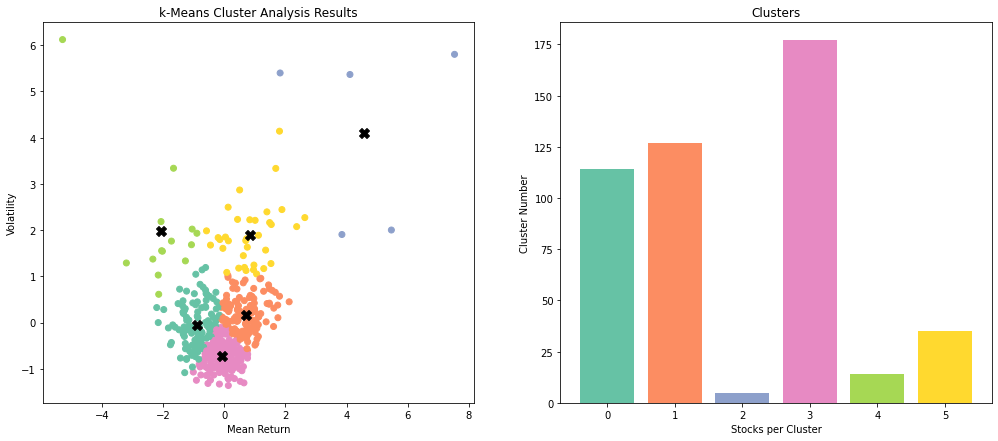

In [252]:
CLUSTERS = 6

# Fit the model
k_means = KMeans(n_clusters=CLUSTERS)
k_means.fit(X)
prediction = k_means.predict(X)
centers = k_means.cluster_centers_

# Plot the results
fig = plt.figure(figsize = (17,7))
colors = cm.get_cmap('Set2')

# Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(X.iloc[:,0], X.iloc[:,1], c = colors(k_means.labels_), cmap="Set2")
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=1, marker='X')
plt.title('k-Means Cluster Analysis Results')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')

# Cluster Sizes
plt.subplot(1, 2, 2)
cluster_sizes = Counter(k_means.labels_)
counts = sorted(cluster_sizes.items())
x,y = [str(c[0]) for c in counts], [c[1] for c in counts]
plt.bar(x=x, height=y, color = colors([int(i) for i in x]))
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()


We might also be interested in the relative sizes of the clusters.

Just to experiment a little bit, let us see a few stocks in each cluster. They might give us intuition what is captured within each cluster.

In [253]:
ticker_to_cluster = pd.Series(index=X.index, data=k_means.labels_)
for i in range(CLUSTERS):
    print("Cluster {}: {}".format(i, np.random.choice(ticker_to_cluster[ticker_to_cluster == i].index, 5)))

Cluster 0: ['KMB' 'PSA' 'BWA' 'FLT' 'ABBV']
Cluster 1: ['TDY' 'MGM' 'HPQ' 'FDX' 'MKTX']
Cluster 2: ['FCX' 'OKE' 'OKE' 'OKE' 'OKE']
Cluster 3: ['YUM' 'UPS' 'GD' 'COO' 'K']
Cluster 4: ['VTRS' 'UAA' 'HWM' 'DXCM' 'ENPH']
Cluster 5: ['DXC' 'APA' 'ZBRA' 'MPC' 'LNC']


In a previous version we explored other clustering algorithms but picked ```k-means``` due to its superior ```silhouette score```. This score is given by the simple formula

$$
\text{silhouette_score} = \frac{d_{inter}-d_{intra}}{\max(d_{inter},d_{intra})},
$$
where $d_{inter}$ (resp., $d_{intra}$) denote the average inter (resp. intra)-cluster distance.

In [254]:
# Silhouette score for k-means
# TODO ADD: предполагам който го чете ще го знае това, но дали да не сложим малко описание на тоя метрик
print("k-Means:", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))

k-Means: 0.36322877462680553


# Finding cointegration pairs



In [255]:
counts = ticker_to_cluster.value_counts()
print ("Number of clusters: %d" % len(counts))
print ("Number of Pairs: %d" % ((counts-1)*counts//2).sum()) 

Number of clusters: 6
Number of Pairs: 30714


In [290]:
def get_coint_pairs(ticker_data, significance=0.01):
  '''Computes cointegrated pairs among tickers in ticker_data'''
  N = ticker_data.shape[1]
    
  # We limit this since clusters are rather big
  first_N = 15
  pairs = []
  tickers = ticker_data.keys()
  for i in range(first_N):
      for j in range(i+1, N):
          t1 = ticker_data[tickers[i]]            
          t2 = ticker_data[tickers[j]]
          _, pval, _ = coint(t1, t2)
          if pval < significance:
              pairs.append((tickers[i], tickers[j]))
  return pairs
      
def get_pairs_from_clusters(n_clusters, tikcer_to_cluster, data):
  '''Computes cointegrated pairs for each cluster'''
  cluster_lookup = {}
  for cluster_ix in range(n_clusters):
      tickers_in_cluster = ticker_to_cluster[ticker_to_cluster == cluster_ix].index
      ticker_data = data[tickers_in_cluster]
      pairs = get_coint_pairs(ticker_data)
      cluster_lookup[cluster_ix] = pairs
  return cluster_lookup       

In [291]:
cluster_lookup = get_pairs_from_clusters(CLUSTERS, ticker_to_cluster, data)

# Count Total Pairs
pairs = []
for ix in range(CLUSTERS):
    pairs.extend(cluster_lookup[ix])
print('Total Pairs: {}'.format(len(pairs)))

Total Pairs: 113


In [292]:
# Extract data for tickers in pairs
tickers = np.unique(pairs)
tickers_in_pairs = ticker_to_cluster.loc[tickers]
X_pairs = X.T[tickers].T
X_pairs.head()

,returns,volatility
A,-0.255,-0.331
AAPL,-0.254,-0.331
ABBV,-0.253,0.049
ADI,0.739,-0.318
ADM,0.504,0.218


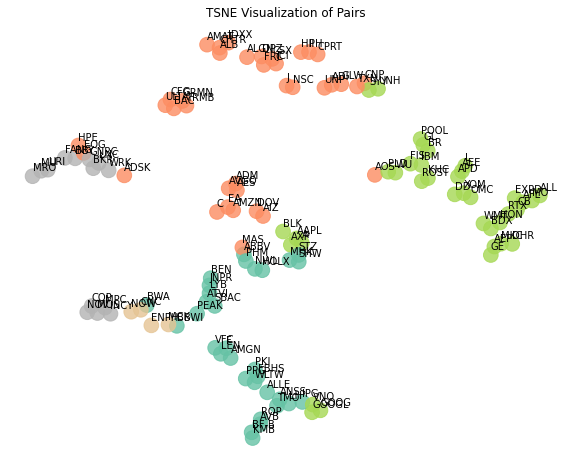

In [293]:
# Use TSNE for visualizations
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

plt.figure(figsize=(10,8))
plt.axis('off')
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=tickers_in_pairs.values, cmap='Set2')
plt.title('TSNE Visualization of Pairs'); 

for x,y,name in zip(X_tsne[:,0], X_tsne[:,1], X_pairs.index):
    plt.annotate(name, (x,y), textcoords="offset points", xytext=(0,5))
    
plt.show()

# Trading strategy

For a pair of stocks A and B, we need evaluate the spread
$$
\text{spread} = r_A - h_c*r_B,
$$
where $r_i$ is the return of the asset $i$, and $h_c$ is the hedge ratio, assumed constant. We calcuate $h_c$ using regression, so that this spread is as close to $0$ as possible.

Recall that in a simple linear correlation of the form
$ Y= \alpha + \beta X+\varepsilon,$ 
we have that $\beta$ is given by: 
$$\beta = \text{cov}(X,Y)/\text{var}(X).$$

In [294]:
def calculate_hedge_ratio(ticker_a, ticker_b, data):
    t_a = data[ticker_a].pct_change()
    t_b = data[ticker_b].pct_change()
    beta = (t_a.cov(t_b))/pd.Series.var(t_b)
    return beta

Let's see them also in parallel.

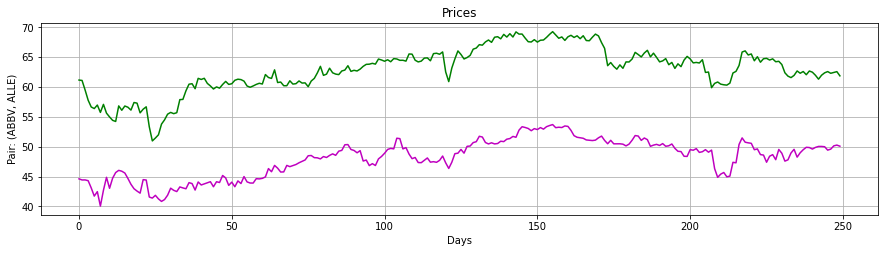

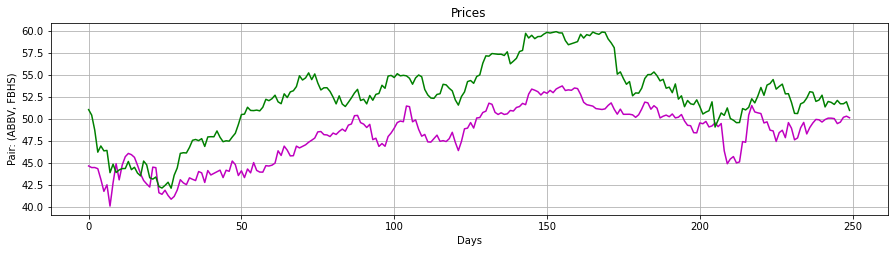

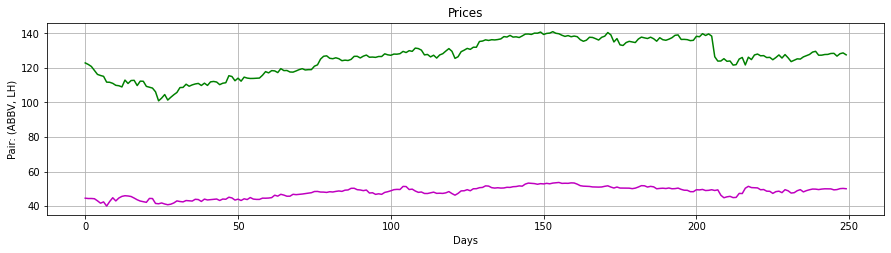

In [295]:
for ix, t in enumerate(pairs[:3]):
    ticker1, ticker2 = t
    df1 = data[ticker1]
    df2 = data[ticker2]
    
    fig = plt.figure(figsize= (15,12))
    plt.subplot(3,1, ix+1)
    plt.plot(range(len(df1)), df1, 'm-')
    plt.plot(range(len(df2)), df2, 'g-')
    plt.xlabel('Days')
    plt.ylabel( "Pair: ({}, {})".format(ticker1, ticker2))
    plt.title('Prices')
    plt.grid()
plt.show()

In comparison, if we pick two random stocks in the index their residuals look like this

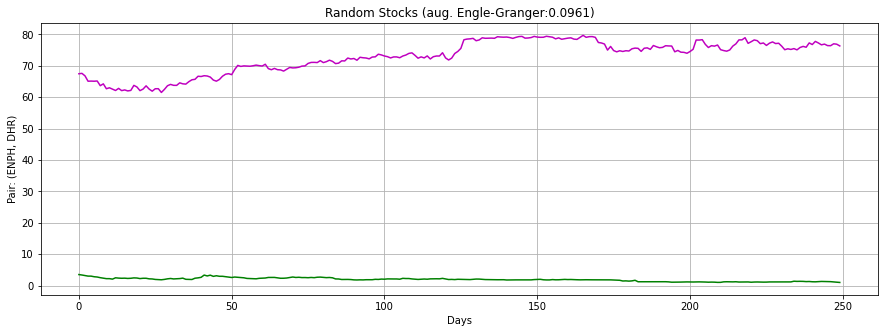

In [296]:
ticker1, ticker2 = np.random.choice(data.columns, 2)
rand_df1 = data[ticker1]
rand_df2 = data[ticker2]

fig = plt.figure(figsize= (15, 5))
plt.plot(range(len(rand_df1)), rand_df1 , 'g-')
plt.plot(range(len(rand_df2)), rand_df2 , 'm-')
plt.xlabel('Days')
plt.ylabel( "Pair: ({}, {})".format(ticker1, ticker2))
plt.title('Random Stocks (aug. Engle-Granger:{})'.format(
    np.around(coint(rand_df1,rand_df2)[1], 4)
))
plt.grid()
plt.show()


### Implementing the strategy 


For each pair we evaluate the z-score

$$
z = \frac{r_i - \mu_i}{\hat{\sigma}},
$$

where both the mean and the standard deviation are the rolling-estimates for ```LOOKBACK_PERIOD``` periods. 



In [297]:
# Set Hyperparameters
LOOKBACK_PERIOD = 21
FLOOR = -1
CEIL = 1
EXIT = 2.2

#Add Stop Loss 
MAX_PERCENTAGE_LOSS = 50

# TODO
INTEREST_RATE = 0.0008

In [298]:
def create_spread(ticker_a, ticker_b,data):
  df1 = data[ticker_a]
  df2 = data[ticker_b]
  df = pd.DataFrame(index = df1.index)
  df['X'] = df1
  df['Y'] = df2

  # computing the hedge ratio (beta of the strategy)
  # EDIT: тук добавих min_periods защото иначе за първите 21 неща нямаше data и го правеше nan
  # което не правеше проблем преди но с този dataset прави
  df['cov'] = df.rolling(LOOKBACK_PERIOD).cov().unstack()['X']['Y']
  df['var'] = df['Y'].rolling(LOOKBACK_PERIOD).var()
  df['Hedge ratio'] = df['cov']/df['var']

  # column with spread
  df['Spread'] = df['X'] - df['Hedge ratio']*df['Y']
  return df


In [299]:
def long_short_strat(ticker_a, ticker_b, data):
  df = create_spread(ticker_a, ticker_b, data)
  df['Z-score'] = (df['Spread'] - df['Spread'].rolling(LOOKBACK_PERIOD).mean())\
                  /(df['Spread'].rolling(LOOKBACK_PERIOD).std())

  # Buy vs Sell signals
  df['Long'] =  (df['Z-score'] < FLOOR)*1
  df['Short']= (df['Z-score'] > CEIL)*1
  df['Exit'] = (np.abs(df['Z-score'])>EXIT)*1
  
  df['In Long'] = (((df['Long'] == 1) & (~(df['Exit'] == 1))))*1
  df['In Short'] = (((df['Short'] == 1) & (~(df['Exit'] == 1))))*1

  return df


In [300]:
def compute_returns(investment, ticker_a, ticker_b, data):
    df = long_short_strat(ticker_a, ticker_b, data)
    portfolio = pd.DataFrame(index = df.index)

    portfolio['Positions'] = df['In Long'] - df['In Short']
    portfolio['X'] = -1.0 * df['X'] * portfolio['Positions']
    portfolio['Y'] = df['Y'] * portfolio['Positions']
    portfolio['Total']= portfolio['X'] + portfolio['Y']

    # Show percentage returns
    portfolio['Returns']= portfolio['Total'].pct_change()
    portfolio['Returns'].fillna(0.0, inplace = True)
    portfolio['Returns'].replace([np.inf, -np.inf], 0.0, inplace = True)
    portfolio['Returns'].replace(-1.0, 0.0, inplace = True)
    
    # Equity curve
    portfolio['Returns'] = (1.0 + portfolio['Returns']).cumprod()
    
    # EDIT: тук как променяме sharpe ratio-то по-долу?
    # (в случай, че сме излезли от позицията)
    mu = portfolio['Returns'].mean()
    sigma = portfolio['Returns'].std()
    sharpe = np.sqrt(250)*((mu)/sigma) - INTEREST_RATE
    
    # EDIT: тук деля на 100,  че беше *100 (realno kak go smqtame tova :D)
    # ще сменя формулата защото тази дава 2000% ако не деля на 100 и 
    # ако сме много under и накрая се вдигнем нагоре пак ще го изкара отрицателно
    # returns_to_date = mu*len(portfolio.index)/100
    
    
    
    # Calculate if Stop Loss Condition has been met
    loss_indices = portfolio[portfolio['Returns'] <= MAX_PERCENTAGE_LOSS/100].index
    if loss_indices.any():
        terminate_after = min(loss_indices)
        portfolio.at[terminate_after:, 'Returns'] = MAX_PERCENTAGE_LOSS/100
#         returns_to_date = -MAX_PERCENTAGE_LOSS/100 # с новата формула нямаме нужда от това
    
    
    
    # Calculate Portfolio
    portfolio['Trade Returns'] = portfolio['Total'].pct_change()
    portfolio['Portfolio Value'] = investment*portfolio['Returns']
    portfolio['Portfolio Returns'] = portfolio['Portfolio Value'].pct_change()
    portfolio['Initial Value'] = investment
    
    returns_to_date = ((portfolio['Portfolio Value'][-1] - investment)/investment)*100
  

    with plt.style.context(['bmh', 'seaborn-paper']):
        fig = plt.figure(figsize= (15,5))
        plt.plot(portfolio['Portfolio Value'])
        plt.plot(portfolio['Initial Value'])
        plt.title("Pair ({},{}), Profit to Date: {}%, Sharpe Ratio: {}".format(
                  ticker_a,
                  ticker_b,
                  np.around(returns_to_date, 2),
                  np.around(sharpe, 2)
                  ))
        plt.xticks([])
        plt.show()
    return 



### Computing the returns

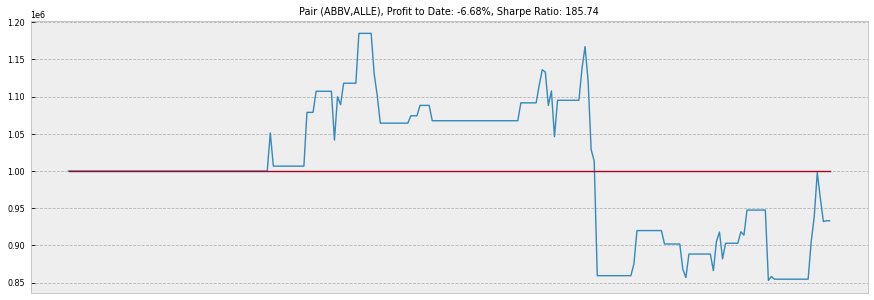

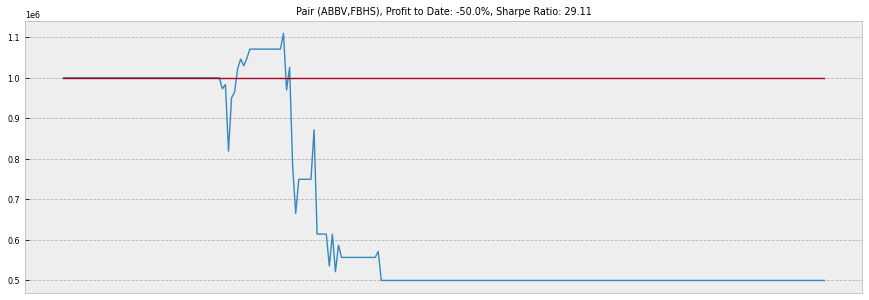

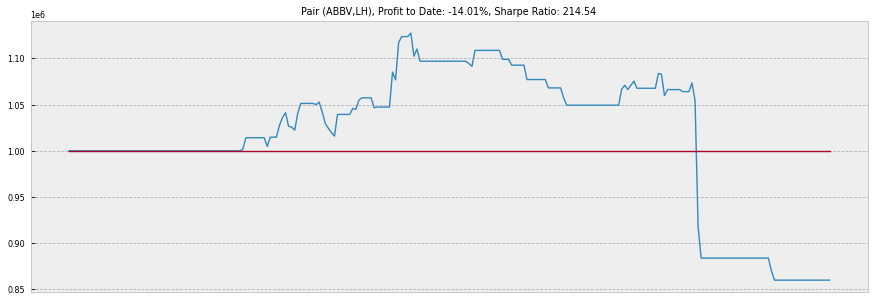

In [301]:
for stock1, stock2 in pairs[:3]: 
    compute_returns(1000000,stock1,stock2, data)

As a benchmark of the performance, we attempt our strategy on a random pair in the S&P500 index.

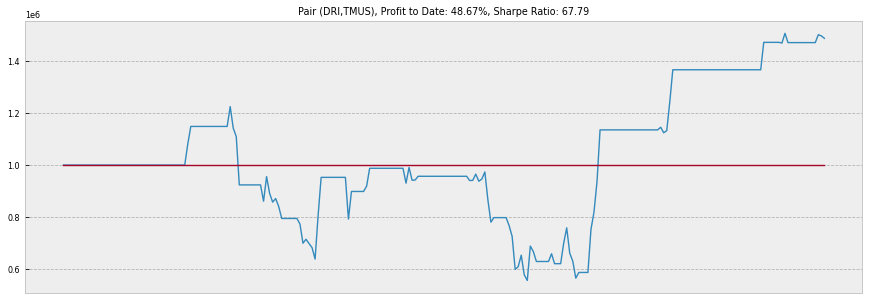

In [302]:
rand_ticker1, rand_ticker2 = np.random.choice(test_data.columns, 2)
compute_returns(1000000, rand_ticker1, rand_ticker2, test_data)

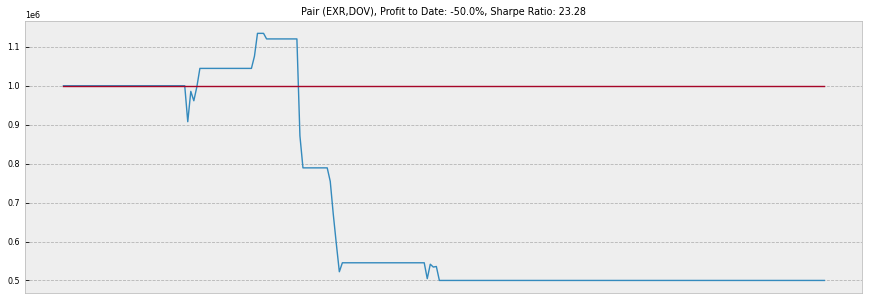

In [303]:
compute_returns(1000000, 'EXR', 'DOV', test_data)

Remark: Really weird result on (EXR, DOV)

# Adding Bid Ask Spread

Here we incorporate Bid-Ask Spread. 



## Estimating bid-ask spread without intraday information

In this section, we include an algorithm that estimates the size of the bid-ask spread of a stock's price given only daily date. We follow [Corwin and Schultz (2012)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.2012.01729.x) (CS) method for estimating volatilities and bid-ask spreads from OHLCV data.

### Mathematical details

We just provide few mathematical details illustrating the CS method. The estimator used is High-Low estimator, which is asssumed to combine information about volatity of the stock and its bid ask-spread. The main underlying assumptions, which allow to estimate these two contributions, are

* daily high (resp. low) prices are buyer (resp. seller) - initiated trades.
* high-low price variance's component in High-Low grows proportionately to the length of the trading interval, while bid-ask does not.

To leverage the second property, CS uses 2-day period. Introduce the notation:

* $S$ - spread, assumed constant over 2-day periods. This means that for each transaction on a stock bought (resp. sold), we pay (resp. gain) $S/2$% 'extra' (resp. 'less). 
* $\beta$ - the expected squared return over a 2-day period:

$$
  \mathbb{E}\Big[\ln^2\frac{H_t}{L_t} + \ln^2\frac{H_{t+1}}{L_{t+1}}\Big] ,
$$
where $H_t$ and $L_t$ are the observed prices at time period $t$.

* Let $\alpha$ be given by 
$$
\alpha = \frac{\sqrt{2\beta}-\sqrt{\beta}}{3-2\sqrt{2}} - \sqrt{\frac{\gamma}{3-2\sqrt{2}}},
$$
where $\gamma$ is the "max-min return" squared over a two day-period:
$$
\gamma  = \ln^2 \Big(\frac{\max(H_{t},H_{t+1})}{\max(L_{t},L_{t+1})}\Big)
$$

Then, under some assumptions, Corwin and Schultz propose that 
$$
S =2\frac{e^{\alpha}-1}{1+e^\alpha}.
$$

Despite indimidating-looking, the formula for $\alpha$ is convenient since it is closed form and allows for direct substitution for $S$.


### Estimating the parameters of the spread

For $\beta$, we estimate the average as a rolling average for a 30-day period (monthly), i.e. 21 trading days. We incorporate a few of the adjustments of Corwin and Schultz, namely

* To account for overnight changes in price, we adjust as follows:
 1. If $L_{t+1}>H_t$, we decrease both $H_{t+1}$ and $L_{t+1}$ by $L_{t+1}-H_t$
 2. If $L_t>H_{t+1}$, we increase both $H_{t+1}$ and $L_{t+1}$ by $L_{t}-H_{t+1}$.

* All negative 2-day spreads are set to zero before calculating monthly averages. This occurs when $\alpha<0$. For example, thi is if the observed 2-day variance is more than twice as large as the single day one, traditionally when there is a lot of volatility in the markets.
 


In [304]:
raw_data.head(5)

high                                                              \
ticker          A    AAL     AAP    AAPL   ABBV     ABC   ABMD    ABT     ACN   
date                                                                            
2016-01-04  41.19  41.35  154.48  26.343  58.32  102.64  89.42  44.05  102.65   
2016-01-05  40.95  41.49  153.79  26.462  58.25  103.40  87.30  43.20  102.87   
2016-01-06  40.99  41.70  150.05  25.593  57.56  102.64  87.13  42.98  103.06   
2016-01-07  40.15  41.52  149.46  25.032  57.84  101.15  84.88  42.18  100.84   
2016-01-08  39.71  41.36  149.44  24.778  57.81   99.51  85.71  41.90   99.81   

                   ...    low                                              \
ticker       ADBE  ...    XEL   XLNX    XOM   XRAY    XYL     YUM     ZBH   
date               ...                                                      
2016-01-04  92.00  ...  35.39  45.36  76.46  58.29  35.60  50.784  100.17   
2016-01-05  92.85  ...  35.19  45.61  76.92  58.90  35.51  51.265  101.60   
2016-01-06  91.50  ...  35.74  45.17  76.59  58.85  35.22  50.913  102.37   
2016-01-07  91.40  ...  36.06  43.74  75.90  58.04  34.49  49.375  101.43   
2016-01-08  89.99  ...  36.08  42.84  74.50  56.89  34.28  48.864  101.37   

                                 
ticker       ZBRA   ZION    ZTS  
date                             
2016-01-04  65.62  26.23  46.75  
2016-01-05  64.62  26.24  47.28  
2016-01-06  61.55  25.47  47.26  
2016-01-07  58.11  24.81  46.29  
2016-01-08  58.97  24.55  45.65  

[5 rows x 994 columns]

In [305]:
# Get daily High/Low
raw_inpairs_high = raw_data['high'][data.columns]
raw_inpairs_low = raw_data['low'][data.columns]

In [306]:
# Adjust Prices according to conditions 1. and 2.
raw_inpairs_adj_low = raw_inpairs_low.copy()
raw_inpairs_adj_high = raw_inpairs_high.copy()

for ix in range(len(raw_inpairs_low)-1):
    rows_cond1 = raw_inpairs_low.iloc[ix][raw_inpairs_low.iloc[ix+1] > raw_inpairs_high.iloc[ix]].index
    rows_cond2 = raw_inpairs_low.iloc[ix][raw_inpairs_low.iloc[ix] > raw_inpairs_high.iloc[ix+1]].index
    
    raw_inpairs_adj_low.iloc[ix+1][rows_cond1] -= (raw_inpairs_low.iloc[ix+1] - raw_inpairs_high.iloc[ix])[rows_cond1]
    raw_inpairs_adj_high.iloc[ix+1][rows_cond1] -= (raw_inpairs_low.iloc[ix+1] - raw_inpairs_high.iloc[ix])[rows_cond1]
    
    raw_inpairs_adj_low.iloc[ix+1][rows_cond1] += (raw_inpairs_low.iloc[ix] - raw_inpairs_high.iloc[ix+1])[rows_cond1]
    raw_inpairs_adj_high.iloc[ix+1][rows_cond1] += (raw_inpairs_low.iloc[ix] - raw_inpairs_high.iloc[ix+1])[rows_cond1]


In [307]:
# Calculate beta
T = 21
SHIFT = 22
beta_df = pd.DataFrame(index=raw_inpairs_high.index, columns = data.columns)

# Shift indices so we always have a positive index
for t in range(SHIFT, len(beta_df.index)):
    val = 0
    for ix in range(0,T):
        val += np.log(raw_inpairs_adj_high.iloc[t-T-1+ix]/raw_inpairs_adj_low.iloc[t-T-1+ix])**2 +\
              np.log(raw_inpairs_adj_high.iloc[t-T+ix]/raw_inpairs_adj_low.iloc[t-T+ix])**2

    val*= (1/T)
    beta_df.iloc[t] = val
beta_df = beta_df.iloc[SHIFT:]
beta_df.fillna(method='ffill')
beta_df = beta_df.apply(pd.to_numeric)
beta_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XLNX,XOM,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-02-04,0.002,0.005,0.003,0.002,0.005,9.215e-04,0.004,0.002,0.001,0.002,...,0.011,0.001,0.002,0.002,0.001,0.001,0.002,0.005,0.003,0.002
2016-02-05,0.002,0.005,0.002,0.002,0.005,1.291e-03,0.004,0.002,0.001,0.002,...,0.011,0.002,0.002,0.002,0.002,0.001,0.002,0.005,0.004,0.002
2016-02-08,0.002,0.005,0.002,0.002,0.006,1.723e-03,0.005,0.002,0.001,0.002,...,0.010,0.002,0.002,0.002,0.002,0.002,0.002,0.005,0.004,0.002
2016-02-09,0.002,0.005,0.003,0.002,0.006,1.778e-03,0.008,0.002,0.001,0.003,...,0.011,0.002,0.002,0.002,0.002,0.002,0.002,0.005,0.004,0.002
2016-02-10,0.002,0.005,0.003,0.002,0.006,1.785e-03,0.009,0.002,0.001,0.004,...,0.010,0.002,0.002,0.002,0.002,0.002,0.002,0.005,0.004,0.002


In [308]:
gamma_df = pd.DataFrame(index=raw_inpairs_high.index, columns =data.columns)

for t in range(1, len(gamma_df.index)):
    gamma_df.iloc[t] = np.log(np.maximum(raw_inpairs_adj_high.iloc[t-1],raw_inpairs_adj_high.iloc[t])\
                         /np.maximum(raw_inpairs_adj_low.iloc[t-1],raw_inpairs_adj_low.iloc[t]))**2

gamma_df = gamma_df[SHIFT:]
gamma_df.fillna(method='ffill')
gamma_df = gamma_df.apply(pd.to_numeric)


In [309]:
alpha_df = pd.DataFrame(index=gamma_df.index, columns = data.columns)
alpha_df = (np.sqrt(2*beta_df)-np.sqrt(beta_df))/(3-2*np.sqrt(2)) - np.sqrt(gamma_df/(3-2*np.sqrt(2)))
alpha_df.fillna(method='ffill')
alpha_df = alpha_df.apply(pd.to_numeric)


In [310]:
spreads_df = pd.DataFrame(index=alpha_df.index, columns =  data.columns)


spreads_df = 2*(np.exp(alpha_df) - 1)/(1+np.exp(alpha_df))
spreads_df[spreads_df < 0] = 0
spreads_df.head(5)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XLNX,XOM,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-02-04,0.048,0.043,0.009,0.051,0.092,0.027,0.067,0.055,0.002,0.033,...,0.089,0.048,0.059,0.036,0.000,0.030,0.059,0.029,0.039,0.051
2016-02-05,0.049,0.045,0.072,0.050,0.094,0.000,0.000,0.059,0.043,0.044,...,0.096,0.049,0.060,0.069,0.000,0.000,0.066,0.033,0.042,0.055
2016-02-08,0.006,0.043,0.045,0.022,0.017,0.003,0.000,0.034,0.000,0.000,...,0.138,0.017,0.047,0.030,0.025,0.000,0.060,0.016,0.056,0.062
2016-02-09,0.010,0.045,0.044,0.053,0.093,0.035,0.000,0.055,0.002,0.000,...,0.068,0.029,0.060,0.031,0.019,0.032,0.000,0.048,0.009,0.032
2016-02-10,0.027,0.098,0.045,0.046,0.089,0.032,0.151,0.045,0.048,0.027,...,0.117,0.056,0.059,0.053,0.060,0.043,0.047,0.008,0.071,0.019


# Pairs Trading class and tuning


## Class 

Now that we have estimates for the bid-ask spreads, we can wrap our strategy in a class. We will also add fixed rate transaction costs and will preiodically test if the stocks are still cointegrated.

In [311]:
class PairsTrading:
  def __init__(self, data, spread_df = None, transaction_cost_pct = 0, significance  = 0.03,
                retest_coint_period = None, LOOKBACK_PERIOD=21, 
                FLOOR=-1, CEIL = 1, EXIT = 2.2, interest_rate=0.0008, MAX_PERCENTAGE_LOSS=50):
      self.data = data
      self.spread_df = spread_df
      self.LOOKBACK_PERIOD = LOOKBACK_PERIOD
      self.FLOOR = FLOOR
      self.CEIL = CEIL
      self.EXIT = EXIT
      self.significance = significance
      self.transaction_cost_pct = transaction_cost_pct
      self.retest_coint_period = retest_coint_period
      self.spreads = spread_df is not None
      self.retest = retest_coint_period is not None
      self.interest_rate = interest_rate
      self.MAX_PERCENTAGE_LOSS = MAX_PERCENTAGE_LOSS
  
  def test_coint_pairs(self, ticker_a, ticker_b, start, end):
      '''Tests if the stocks are still cointegraated'''
      data = self.data
      t1 = data[ticker_a].iloc[start:end]            
      t2 = data[ticker_b].iloc[start:end]
      t1 = t1.fillna(method = 'ffill')
      t2 = t2.fillna(method = 'ffill')
      score, pval, _ = coint(t1, t2)
      if pval < self.significance:
          return True
      return False
  
  def compute_returns(self, investment, ticker_a, ticker_b, plot = True, return_portfolio=False):
      data = self.data
      spreads_data = self.spread_df
      df = self.long_short_strat(ticker_a, ticker_b)
      portfolio = pd.DataFrame(index = df.index)
      portfolio['Positions'] = df['In Long'] - df['In Short']
      
      
      if self.spreads:
          sx = spreads_data.loc[data.index][ticker_a]
          sy = spreads_data.loc[data.index][ticker_b]
          df['sx'] = sx.values
          df['sy'] = sy.values
          portfolio['X'] = -1.0 * df['X'] * portfolio['Positions'] * (1 + portfolio['Positions']*df['sx']/2)
          portfolio['Y'] = df['Y'] * portfolio['Positions'] * (1 + (-1)*portfolio['Positions']*df['sy']/2)
      else:
          portfolio['Positions'] = df['In Long'] - df['In Short'] 
          portfolio['X'] = -1.0 * df['X'] * portfolio['Positions']
          portfolio['Y'] = df['Y'] * portfolio['Positions']
      
      portfolio['Total']= portfolio['X'] + portfolio['Y']\
                              - self.transaction_cost_pct*(portfolio['X']+portfolio['Y'])
      
      # Show percentage returns
      portfolio['Returns']= portfolio['Total'].pct_change()
      portfolio['Returns'].fillna(0.0, inplace = True)
      portfolio['Returns'].replace([np.inf, -np.inf], 0.0, inplace = True)
      portfolio['Returns'].replace(-1.0, 0.0, inplace = True)
      

      # Computing relevant statistics (TO COMPLETE LATER)
      mu = portfolio['Returns'].mean()
      sigma = portfolio['Returns'].std()
      # Sharpe Ratio Annualized (250 trading days)
      sharpe = np.sqrt(250)*(mu)/sigma - self.interest_rate
#       returns_to_date = mu*len(portfolio.index)*100
        

      # Equity curve
      portfolio['Returns'] = (1.0 + portfolio['Returns']).cumprod() 
      loss_indices = portfolio[portfolio['Returns'] <= self.MAX_PERCENTAGE_LOSS/100].index
      if loss_indices.any():
        terminate_after = min(loss_indices)
        portfolio.at[terminate_after:, 'Returns'] = self.MAX_PERCENTAGE_LOSS/100
#         returns_to_date = -self.MAX_PERCENTAGE_LOSS
    
      portfolio['Trade Returns'] = portfolio['Total'].pct_change()
      portfolio['Portfolio Value'] = investment*portfolio['Returns']
      portfolio['Portfolio Returns'] = portfolio['Portfolio Value'].pct_change()
      portfolio['Initial Value'] = investment
      returns_to_date = ((portfolio['Portfolio Value'][-1] - investment)/investment)*100
      
      if plot:
          with plt.style.context(['bmh', 'seaborn-paper']):
              plt.plot(portfolio['Portfolio Value'])
              plt.plot(portfolio['Initial Value'])
              plt.xticks([])
              plt.title("Pair ({},{}), Profit to Date: {}%, Sharpe Ratio: {}".format(
                        ticker_a,
                        ticker_b,
                        np.around(returns_to_date, 3),
                        np.around(sharpe, 2)
                        ))
              plt.show()
      if return_portfolio:
          return returns_to_date, sharpe, portfolio
      else:
          return returns_to_date, sharpe


  def create_spread(self, ticker_a, ticker_b):
      data = self.data
      df1 = data[ticker_a]
      df2 = data[ticker_b]
      df = pd.DataFrame(index = df1.index)
      df['X'] = df1
      df['Y'] = df2
      # computing the hedge ratio (beta of the strategy)
      df['cov'] = df.rolling(LOOKBACK_PERIOD).cov().unstack()['X']['Y']
      df['var'] = df['Y'].rolling(LOOKBACK_PERIOD).var()
      df['Hedge ratio'] = df['cov']/df['var']
      
      # column with spread
      df['Spread'] = df['X'] - df['Hedge ratio']*df['Y']
      return df
  
  def long_short_strat(self, ticker_a, ticker_b):
      data = self.data
      df = self.create_spread(ticker_a, ticker_b)
      df['Z-score'] = (df['Spread'] - df['Spread'].rolling(self.LOOKBACK_PERIOD).mean())\
                      /(df['Spread'].rolling(self.LOOKBACK_PERIOD).std())
      
      # Buy vs Sell signals
      df['Long'] =  (df['Z-score'] < self.FLOOR)*1
      df['Short']= (df['Z-score'] > self.CEIL)*1
      df['Exit'] = (np.abs(df['Z-score'])> self.EXIT)*1
      
      
      # Test if stocks are still cointegrated
      coint_test = pd.DataFrame(index=df.index)
      if self.retest:
          for ix in range(len(df)-self.retest_coint_period):
              still_coint = self.test_coint_pairs(ticker_a, 
                                                  ticker_b, 
                                                  ix, 
                                                  ix+self.retest_coint_period)
              
              coint_test.iloc[ix:ix+self.retest_coint_period] = (not still_coint)*1
      # If stocks are not cointegrated, exit    
      df['Exit'] = df['Exit'] ^ coint_test

      df['In Long'] = (((df['Long'] == 1) & (~(df['Exit'] == 1))))*1
      df['In Short'] = (((df['Short'] == 1) & (~(df['Exit'] == 1))))*1

      return df



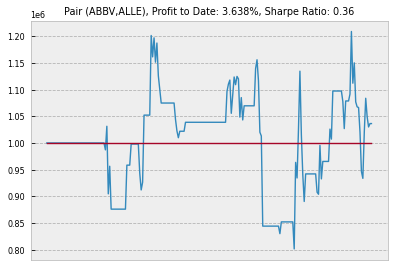

(3.637978332894586, 0.35571156631774076)

In [312]:
pt = PairsTrading(data=data.iloc[SHIFT:],
                  spread_df=spreads_df,
                  LOOKBACK_PERIOD = LOOKBACK_PERIOD,
                  FLOOR = FLOOR,
                  CEIL = CEIL,
                  EXIT = EXIT,)
stock1, stock2 = pairs[0]
pt.compute_returns(1000000,stock1,stock2)

In [313]:
ceil = [x for x in np.arange(0.8, 1.6, 0.2)]
exit = [x for x in np.arange(1.8, 2.4, 0.2)]
retest_period = [None, 90, 180]
transaction_cost_pct = 0.02
print("Search Space Size: {}".format(len(ceil)*len(exit)*len(retest_period)))


Search Space Size: 36


## Tuning the hyperparameters

Lastly, we use grid search to optimize the hyperparameters of our strategy.

In [280]:
results = []
NUM_PAIRS  = 10
investment = 1e6
for c in ceil:
    if results:
        print('Best So Far: {}'.format(max(results, key = lambda x: x[-1])))
    for ex in exit:
        for rtp in retest_period:
            pt = PairsTrading(data=data.iloc[SHIFT:],
                              spread_df=spreads_df,
                              transaction_cost_pct=transaction_cost_pct,
                              retest_coint_period=rtp,
                              FLOOR = c*-1,
                              CEIL = c,
                              EXIT = ex)
            r = []
            for pair in pairs[:NUM_PAIRS]:
                ret, shp = pt.compute_returns(investment, *pair, plot=False)
                r.append(shp)
            results.append((c,-1*c,ex,rtp,np.median(r)))

Best So Far: (0.8, -0.8, 1.8, None, 0.14017281032122722)
Best So Far: (1.0, -1.0, 1.8, None, 0.4636950920186894)
Best So Far: (1.2, -1.2, 1.8, None, 0.46529322324141276)


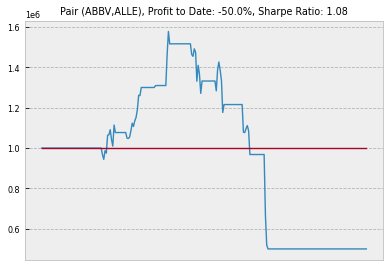

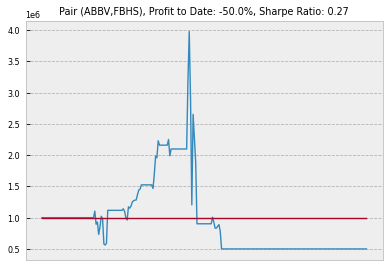

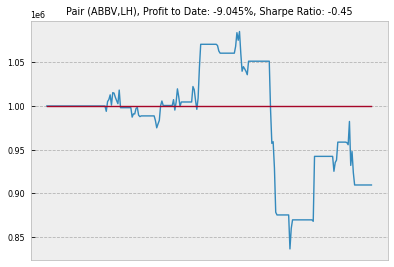

In [314]:
best = max(results, key = lambda x: x[-1])
c, f, ex, rtp, _ = best

investment = 1e6
pt_test = PairsTrading(data=test_data,
                  spread_df=spreads_df,
                  transaction_cost_pct=transaction_cost_pct,
                  retest_coint_period=rtp,
                  FLOOR = f,
                  CEIL = c,
                  EXIT = ex)

pt_train = PairsTrading(data=data[SHIFT:],
                  spread_df=spreads_df,
                  transaction_cost_pct=transaction_cost_pct,
                  retest_coint_period=rtp,
                  FLOOR = f,
                  CEIL = c,
                  EXIT = ex)


returns = []
for pair in pairs[:3]:
    ret = pt_test.compute_returns(investment, *pair)
    returns.append(ret)

### Backtest on a basket of pair trades

We now trade a full basket of pair trades. We have weighted the strategies by their p-values, where a pair with lower p-value is considered as a more cointegrated, so it constitutes bigger portion of our portfolio. 

Remark: Even though we run cointegration tests at regular intervals, in this version we do not dynamically update the weights accordingly.

In [315]:
initial_investment = 1e6
pairs_dict = {}

for pair in pairs:
  ticker_1 = pair[0]
  ticker_2 = pair[1]
  # EDIT: тук алтернативно може mean returns vmesto samo ret, no ret otkrih che raboti po-dobre
  ret, shp, portfolio = pt_train.compute_returns(initial_investment, *pair, plot=False, return_portfolio=True)
  pairs_dict[pair] = ret, shp


In [316]:
threshold = 0 # EDIT: s tova moje da si pogiraem
basket = pd.DataFrame.from_dict(pairs_dict, orient='index',columns = ["returns", "sharpe"])
basket = basket[basket['returns'] > threshold]

print("{} Pairs chosen".format(basket.shape[0]))

basket['weights'] = basket['returns']/sum(basket['returns'])

basket.head(10)

53 Pairs chosen


,returns,sharpe,weights
"(ABBV, NWL)",57.357,0.917,0.033
"(ABBV, PHM)",10.862,0.641,0.006
"(ABBV, SBAC)",5.536,0.340,0.003
"(ALLE, FBHS)",175.113,1.714,0.100
"(ALLE, PHM)",8.321,0.591,0.005
"(ALLE, TMO)",5.344,0.408,0.003
"(ATVI, STZ)",4.573,0.339,0.003
"(AVB, F)",3.657,0.424,0.002
"(AVB, PPG)",15.283,0.587,0.009
"(AVB, SHW)",12.953,0.535,0.007


In [317]:
# Sanity check. The weights must add up to 1
sum(basket['weights'])

0.9999999999999998

In [318]:
basket['allocation'] = basket['weights']*initial_investment
basket.head()

,returns,sharpe,weights,allocation
"(ABBV, NWL)",57.357,0.917,0.033,32833.179
"(ABBV, PHM)",10.862,0.641,0.006,6217.902
"(ABBV, SBAC)",5.536,0.340,0.003,3169.079
"(ALLE, FBHS)",175.113,1.714,0.100,100241.113
"(ALLE, PHM)",8.321,0.591,0.005,4762.965


In [319]:
basket_returns = []

portfolios = pd.DataFrame()

for pair in basket.index:
    ret, _, port = pt_test.compute_returns(basket['allocation'][pair], 
                                           *pair, 
                                           plot=False, 
                                           return_portfolio=True)
    basket_returns.append(ret/100)
    portfolios[pair] = port['Returns']
    
basket_returns = np.array(basket_returns)
basket['money_after'] = basket['allocation']*(1+basket_returns)

In [320]:
basket.head(10)

,returns,sharpe,weights,allocation,money_after
"(ABBV, NWL)",57.357,0.917,0.033,32833.179,97178.702
"(ABBV, PHM)",10.862,0.641,0.006,6217.902,10917.887
"(ABBV, SBAC)",5.536,0.340,0.003,3169.079,3108.798
"(ALLE, FBHS)",175.113,1.714,0.100,100241.113,63389.845
"(ALLE, PHM)",8.321,0.591,0.005,4762.965,3823.110
"(ALLE, TMO)",5.344,0.408,0.003,3059.268,3470.582
"(ATVI, STZ)",4.573,0.339,0.003,2617.879,3261.878
"(AVB, F)",3.657,0.424,0.002,2093.506,1046.753
"(AVB, PPG)",15.283,0.587,0.009,8748.340,4374.170
"(AVB, SHW)",12.953,0.535,0.007,7414.830,4226.342


In [321]:
sum(basket['money_after'])

1223235.9759175617

<AxesSubplot:title={'center':'Mean Returns. Overall Portfolio Return: 22.324%, Overall Portfolio Sharpe: 1.38'}, xlabel='date', ylabel='returns'>

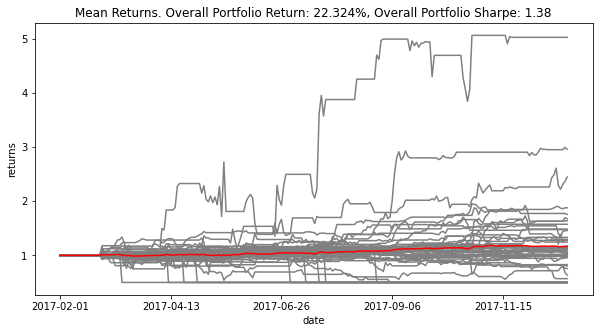

In [322]:
color_dict = {x:'#808080' for x in portfolios.columns} # Grey

portfolios['mean'] = portfolios.mean(axis=1)
color_dict['mean'] = '#FF0000' # Red

basket_sharpe = sum(basket['sharpe']*basket['weights'])
overall_return =  ((sum(basket['money_after'])-investment)/investment)*100


portfolios.iloc[22:].plot(color=color_dict, 
                          legend=False, 
                          figsize=(10,5),
                          xlabel='date',
                          ylabel='returns',
                          title = "Mean Returns. Overall Portfolio Return: {}%, Overall Portfolio Sharpe: {}".format(np.around(overall_return, 3),
                                                                   np.around(basket_sharpe,2)))

Проблеми, с които сме се сблъскали:

*   Stop loss at zero capital -- после в cum prod ставаш отрицателен.

*   The strategy really depends on stop-loss rule -- if we only exit a position if we have lost 100%, then we are up. However, if we exit a pair at at most 50% loss, then we are down.

*   AAL, APA: rapidly cease to be cointegrated. 

*   A, PKI: rapidly cease to be cointegrated. 

In [ ]:
# EDIT:  samo za reutnrs to date da vidim formulata che se durji stranno i mai sme gotovi
# EDIT: taka kato sme s poveche pairs moje da go mahnem tova TSNE :D